In [1]:
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [7]:
gz = 0
anti = 1
gx = 1e-1

L = 5
num_trash = 2
name = f"qsim_params_VQE_Ising_L{L:.0f}_anti_{anti:.0f}_single-jobs"
filename = 'data/' + name
print(filename)
gx_vals = np.logspace(-2,2,logspace_size)

data/qsim_params_VQE_Ising_L5_anti_1_single-jobs


In [9]:
# more in-depth noise models https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html
#backend = qiskit.Aer.get_backend('qasm_simulator') # apparently outdated (legacy)
IBMQ.load_account() # this then automatically loads your saved account
provider = IBMQ.get_provider(hub='ibm-q-research')

real_backend = provider.backends(simulator=False, operational=True)[6]
backend = qiskit.providers.aer.AerSimulator.from_backend(real_backend)
backend_sim = backend

ibmqfactory.load_account:WARNING:2021-05-28 16:46:17,658: Credentials are already in use. The existing account in the session will be replaced.


## Test VQE execution

In [13]:
ansatz = qiskit.circuit.library.EfficientSU2(L, reps=3)
ansatz = qiskit.transpile(ansatz, backend)

#optimizer = SLSQP(maxiter=1000)
#optimizer = COBYLA(maxiter=1000)
optimizer = SPSA(maxiter=1000)

vqe = VQE(ansatz, optimizer, quantum_instance=backend) 

In [14]:
t0 = datetime.datetime.now()
H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
result = vqe.compute_minimum_eigenvalue(H, aux_operators=[QMag(L,anti)]) #ED with Qiskit VQE
print(f"elapsed time {datetime.datetime.now()-t0}")

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


elapsed time 0:04:22.447792


In [15]:
# ED
ED_state, E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
print(f"ED energy: {E} ;; VQE energy: {result.eigenvalue}")
print(f"ED mag: {ED_state.T.conj()@Mag(L,anti)@ED_state} ;; VQE mag: {result.aux_operator_eigenvalues}")

ED energy: -4.0185091477191905 ;; VQE energy: -1.461083984634024
ED mag: (0.9971832823312762+0j) ;; VQE mag: [[0.2972656249999999]]


In [27]:
phis = [sort_params(result.optimal_parameters)] # needs to be called phis for later

### Compare with simulated ED results
get results from simulated VQE and put through the "real" circuit

In [35]:
vqe2 = VQE(qiskit.circuit.library.EfficientSU2(L, reps=3), optimizer, quantum_instance=StatevectorSimulator()) 
t0 = datetime.datetime.now()
result2 = vqe2.compute_minimum_eigenvalue(H, aux_operators=[QMag(L,anti)]) #ED with Qiskit VQE
print(f"elapsed time {datetime.datetime.now()-t0}")

elapsed time 0:00:16.575262


In [36]:
phis.append(sort_params(result2.optimal_parameters))

In [37]:
state = init_vqe(phis[-1], L=L)

In [38]:
state

In [41]:
state = init_vqe(phis[-1], L=L)
state = qiskit.transpile(state, backend)
meas_outcome = ~StateFn(QMag(L,anti)) @ StateFn(state)

Qmag2 = meas_outcome.eval()
e_outcome = ~StateFn(H) @ StateFn(state)
Qen2 = e_outcome.eval()

In [43]:
print(f"ED energy: {E} ;; VQE energy: {result.eigenvalue} ;; VQE energy from simulated: {result2.eigenvalue} ;; VQE simualted but real execution: {Qen2}")
print(f"ED mag: {ED_state.T.conj()@Mag(L,anti)@ED_state} ;; VQE mag: {result.aux_operator_eigenvalues} ;; VQE magfrom simulated: {result2.aux_operator_eigenvalues} ;; VQE simualted but real execution: {Qmag2}")

ED energy: -4.0185091477191905 ;; VQE energy: -1.461083984634024 ;; VQE energy from simulated: -4.016651757443969 ;; VQE simualted but real execution: (-4.012639227671821+4.44e-16j)
ED mag: (0.9971832823312762+0j) ;; VQE mag: [[0.2972656249999999]] ;; VQE magfrom simulated: [[0.9973691421765032]] ;; VQE simualted but real execution: (0.997369142176503+0j)


## Test Training 

In [19]:
##############################################################################
### II - Training  ###########################################################
##############################################################################

thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [20]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [24]:
def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=1000, backend=backend):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    circ = qiskit.transpile(circ, backend)
    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots, seed_simulator=123, seed_transpiler=234) # fix seed to make it reproducible
    return job_sim

In [28]:
phi = phis[0]
job = run_circuit(thetas, L, num_trash, phi)
counts = job.result().get_counts()

In [29]:
counts

{'11': 199, '01': 199, '10': 287, '00': 315}

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [30]:


def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots).result().get_counts()
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=1e-1,
                         #perturbation=0.4
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [31]:
def run_inference(thetas, shots=1000, L=5):
    cost = np.zeros((len(gx_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
            cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
    return cost

In [32]:
# from the original vqe calculated state
thetas, loss, accepted = optimize([0], max_iter=100, L=5) #, pick_optimizer="adam")

Initial cost: 1.073
Time: 87.05973 sec
(array([ 8.62093881,  1.64621556,  4.34012675, -0.08811855, -0.08377322,
        3.80926389,  5.85356059,  5.94192758,  0.23473311, -0.25130999,
       -0.21227317,  1.29001248]), 0.719, 300)


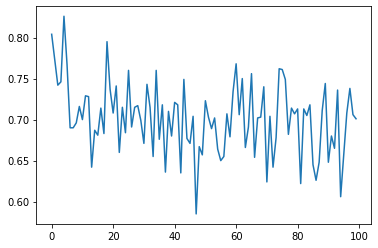

In [33]:
plt.plot(loss)

In [44]:
# using the VQE parameters from simulation
thetas, loss, accepted = optimize([1], max_iter=100, L=5) #, pick_optimizer="adam")

Initial cost: 1.059
Time: 92.52694 sec
(array([ 5.28069876,  4.33928498,  2.33835442,  3.19871708, -0.10435896,
        3.26580548,  1.91447475,  3.54516646,  0.08645491,  0.3357119 ,
        3.43387543,  4.20053885]), 0.783, 300)


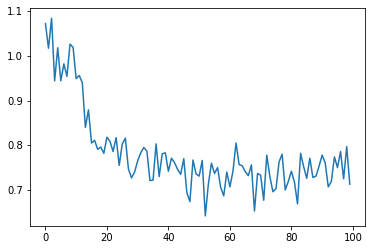

In [45]:
plt.plot(loss)